# Imports

In [1]:
#!pip install pytorch-transformers accelerate evaluate -U

In [2]:
try:
    from mai_nlp_helper_functions import *
except ImportError as e:
    raise ImportError("You don't have the mai_nlp_helper_functions.py file in the same directory as your note book. Either add it, or copy paste the contents in this cell") from e


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

import pandas as pd
import datasets
from sklearn.model_selection import train_test_split
from datasets import Dataset, Features, ClassLabel, Value
from transformers import DataCollatorWithPadding


## Get data

In [4]:
df = pd.read_csv("DATA/esg_reports.csv")
df["labels"] = df["subject"].fillna("Other")
df

,text,subject,labels
0,"Since its inception in 2010, we have distribut...",Social,Social
1,"I will focus first on traffic, which is a key ...",NaN,Other
2,"Also, many farms are aged with degraded soil t...",Environmental,Environmental
3,"Alaska 2009 STEWARDSHIP REPORT54 cOnSERvATIOn,...",Social,Social
4,The company’s U.S. GOM operations can be impac...,NaN,Other
...,...,...,...
2180,American shad are a species of concern for res...,Environmental,Environmental
2181,Weyerhaeuser's policies address best practices...,NaN,Other
2182,compares recently observed trends in weather p...,Environmental,Environmental
2183,"If our partners, including our licensors, suff...",NaN,Other


## Transformers model 1

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [6]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [7]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

sentence = df.iloc[203]["text"]
encoded = preprocess_function({"text":[sentence]})
print(sentence)
print(encoded)
for w in encoded['input_ids'][0]:
    print(w, tokenizer.decode([w]))

Becoming a WindMade Pioneer will help BD communicate our renewable energy use more effectively to customers and company stakeholders.
{'input_ids': [[101, 3352, 1037, 3612, 21565, 7156, 2097, 2393, 1038, 2094, 10639, 2256, 13918, 2943, 2224, 2062, 6464, 2000, 6304, 1998, 2194, 22859, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
101 [CLS]
3352 becoming
1037 a
3612 wind
21565 ##made
7156 pioneer
2097 will
2393 help
1038 b
2094 ##d
10639 communicate
2256 our
13918 renewable
2943 energy
2224 use
2062 more
6464 effectively
2000 to
6304 customers
1998 and
2194 company
22859 stakeholders
1012 .
102 [SEP]


In [8]:
for w in encoded['input_ids'][0]:
    print(w, tokenizer.decode([w]))

101 [CLS]
3352 becoming
1037 a
3612 wind
21565 ##made
7156 pioneer
2097 will
2393 help
1038 b
2094 ##d
10639 communicate
2256 our
13918 renewable
2943 energy
2224 use
2062 more
6464 effectively
2000 to
6304 customers
1998 and
2194 company
22859 stakeholders
1012 .
102 [SEP]


In [9]:
class_names = ["Environmental", "Social", "Other"]
esg_classes = Features({'__index_level_0__': Value('string'), 
                             'text': Value('string'), 
                             'labels': ClassLabel(names=class_names)})


In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
df_train, df_test = train_test_split(df, random_state=22141)
train = Dataset.from_pandas(df_train[["text", "labels"]], features=esg_classes)
test = Dataset.from_pandas(df_test[["text", "labels"]], features=esg_classes)
train

Dataset({
    features: ['__index_level_0__', 'text', 'labels'],
    num_rows: 1638
})

In [12]:
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_test = test.map(preprocess_function, batched=True)
tokenized_train

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Map:   0%|          | 0/1638 [00:00<?, ? examples/s]

Map: 100%|██████████| 547/547 [00:00<00:00, 12731.59 examples/s]


Dataset({
    features: ['__index_level_0__', 'text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1638
})

In [13]:

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

100%|██████████| 103/103 [02:01<00:00,  1.18s/it]

{'train_runtime': 121.614, 'train_samples_per_second': 13.469, 'train_steps_per_second': 0.847, 'train_loss': 0.7143979118865671, 'epoch': 1.0}


TrainOutput(global_step=103, training_loss=0.7143979118865671, metrics={'train_runtime': 121.614, 'train_samples_per_second': 13.469, 'train_steps_per_second': 0.847, 'train_loss': 0.7143979118865671, 'epoch': 1.0})

This takes a long time. I trained this in the cloud instead, results are in the lecture powerpoint.

In [15]:
# If you are runnign for real, save your work!
model.save_pretrained("mymodel")
model = AutoModelForSequenceClassification.from_pretrained("mymodel")


## Evaluate - alternative

In [16]:
# from evaluate import evaluator
# from datasets import load_dataset
# task_evaluator = evaluator("text-classification")

# results = task_evaluator.compute(
#     model_or_pipeline=model,
#     data=tokenized_test,
#     metric="accuracy",
#     label_mapping={
#     "LABEL_0": 0,
#     "LABEL_1": 1,
#     "LABEL_2": 2
#   },
#     # label_mapping=emotion_features["labels"]._str2int,
#     label_column="labels",
#     n_resamples=1,
#     random_state=0,
#     tokenizer=tokenizer
# )

100%|██████████| 35/35 [00:15<00:00,  2.29it/s]


               precision    recall  f1-score   support

Environmental       1.00      1.00      1.00       299
        Other       1.00      1.00      1.00       115
       Social       1.00      1.00      1.00       133

     accuracy                           1.00       547
    macro avg       1.00      1.00      1.00       547
 weighted avg       1.00      1.00      1.00       547



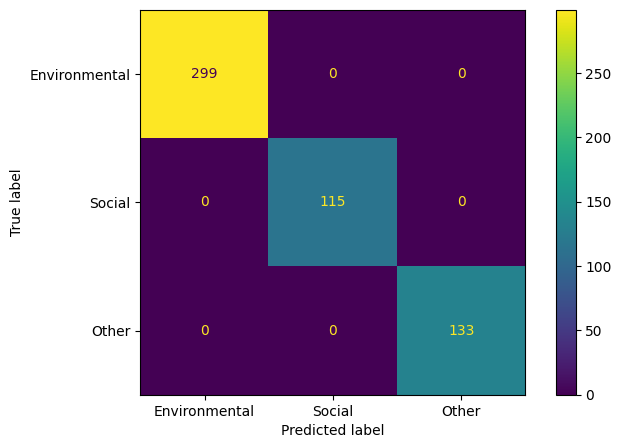

In [17]:

experiment_name = "Transformers dummy"

# predictions = clf.predict(X_test)
predictions = trainer.predict(tokenized_test)
prediction_labels = [class_names[x] for x in predictions.label_ids]

stats = evaluate_model(df_test["labels"], prediction_labels, class_names)
log_experiment_results(experiment_name, stats["macro avg"])